<a href="https://colab.research.google.com/github/PaulPhSpr/Seminararbeit/blob/master/DeepPiCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Das Notebook zum Training des DeepPiCar**

Teil 3 ist adaptiert aus: Tian, David (2019). DeepPiCar - Part 5. Zuletzt abgerufen am 27.05.2020. Verfügbar unter: https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110

# Teil 1 - Import der Bibliotheken

In [1]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 3.0MB 39.7MB/s 
     |████████████████████████████████| 460kB 39.9MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [4]:
#--Standart-Bibliotheken--#
import os #zum Arbeiten mit Dateipfaden
import random 
import numpy as np

#--Machine Learning--#
import tensorflow as tf
from tensorflow.keras.models import Model #zum Zusammenbauen
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense #verschiedene Layer
from tensorflow.keras.optimizers import SGD #Stochastic Gradient Descent
from tensorflow.keras.models import load_model #für das Laden
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#--Graphik--#
import cv2
from imgaug import augmenters as img_aug #Data Augmentation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import ImageFilter, Image #um Bilder zu bearbeiten und anzuzeigen

#--Auswertung--#
!pip3 install deeplearning2020
from deeplearning2020 import helpers #(OpenHPI, 2020)

In [5]:
tf.__version__

'2.2.0'

# Teil 2 - Download der Daten

In [6]:
#--Daten aus GitHub herunterladen--#
!cd /content
!git clone https://github.com/PaulPhSpr/Seminararbeit 

Cloning into 'Seminararbeit'...
remote: Enumerating objects: 5327, done.
remote: Total 5327 (delta 0), reused 0 (delta 0), pack-reused 5327
Receiving objects: 100% (5327/5327), 102.54 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [7]:
#--Speicherorte angeben--#
bas_dir = "Seminararbeit/Datensatz"
train_dir = os.path.join(bas_dir, "train")
valid_dir = os.path.join(bas_dir, "valid")

#--Anzahl der Klassen --#
num_of_classes = 19

# Teil 3 - Data Augmentation

In [8]:
#--Zoom--#
def zoom(bild):
  zoom = img_aug.Affine(scale=(1, 1.3)) #zufälliger zoom zwischen 100% und 130%
  bild = zoom.augment_image(bild)
  return bild

#--Rotation um 180°--#
def flip(bild, steuerwinkel):
  if(np.random.rand() < 0.5):
    bild = cv2.flip(bild, 1)
    steuerwinkel = num_of_classes - 1 - steuerwinkel
  return bild, steuerwinkel

#--Unschärfe--#
def blur(bild):
  kernel = random.randint(1,5) #alles darüber zu verschwommen
  bild = cv2.blur(bild, (kernel, kernel))
  return bild

def hell(bild):
  helligkeit = img_aug.Multiply((0.7, 1.3)) #70%-130%
  bild = helligkeit.augment_image(bild)
  return bild

#--Zusammenbringen--#
def augmentation(bild, steuerwinkel):
  augmentation_prob = 0.7
  if np.random.rand() < augmentation_prob:
    bild = zoom(bild)
  if np.random.rand() < augmentation_prob:
    bild = blur(bild)
  if np.random.rand() < augmentation_prob:
    bild = hell(bild)
  bild, steuerwinkel = flip(bild, steuerwinkel)
  return bild, steuerwinkel

# Teil 4 - Daten vorbereiten für Training

In [9]:
#--Bilder standardisieren--#
def vorbereitung_bild(bild):
  bild = Image.fromarray((bild).astype(np.uint8)) #nur dieses Dateiformat wird von Pillow akzeptiert
  bild = bild.resize((54, 73)) #runterskalieren
  bild = cv2.cvtColor(np.array(bild), cv2.COLOR_BGR2RGB) #in numpy bild umwandeln
  bild = bild[32:,:] #nur untere hälfte relevant
  return bild

#--Aus Categorical zu Numeric, [0, 0, 1, 0] --> 2
def vorbereitung_steuerwinkel(winkel):
  for i in range(num_of_classes):
    if winkel[i] != 0:
      return i

#--Bildgenerator für Trainingsprozess--#
def bild_dat_generator(bilder, steuerwinkel, trainiert, anzahl = 20000):
  batch_bild = []
  batch_steuerwinkel = []

  #so viele Bilder wie angeben ausgeben
  if not trainiert:
    anzahl //= 4 #20% validierungsdaten

  for i in range(anzahl):
    rand_i = random.randint(0, len(bilder)-1) #ein Bild aussuchen

    #bild nehmen
    bild = bilder[rand_i]
    bild = vorbereitung_bild(bild)

    #steuerwinkel nehmen
    str_winkel = steuerwinkel[rand_i]
    str_winkel = vorbereitung_steuerwinkel(str_winkel) 

    #Augmentation
    if(trainiert):
      bild, str_winkel = augmentation(bild, str_winkel)

    bild = cv2.cvtColor(bild, cv2.COLOR_BGR2RGB)
    #Abspeichern
    batch_bild.append(bild)
    batch_steuerwinkel.append(str_winkel)

  return np.asarray(batch_bild), np.asarray(batch_steuerwinkel)

In [10]:
#--Batches--#
classes = ["class" + str(i) for i in range(1, num_of_classes + 1)]
bs_train = 2372
bs_valid = 593
train_batches = ImageDataGenerator().flow_from_directory(train_dir, target_size = (73, 54), classes=classes, batch_size = bs_train) 
valid_batches = ImageDataGenerator().flow_from_directory(valid_dir, target_size = (73, 54), classes=classes, batch_size = bs_valid)

Found 2372 images belonging to 19 classes.
Found 593 images belonging to 19 classes.


In [11]:
#--Trainingsdaten zusammenführen--#
#Trainingsdaten
bilder, label = next(train_batches)
X_train, y_train = bild_dat_generator(bilder, label, True)
#Validierungsdaten
bilder, label = next(valid_batches)
valid_data = bild_dat_generator(bilder, label, False)

# Teil 5 - Baue Modell

In [12]:
def buildModel(dense_neurons = 2000, lr = 0.0001, n = 0):
  #--Params--#
  momentum = 0.9 #Parameter für SGD, entspricht Trägheit beim Abstieg
  #dense_neurons = 2000
  #lr = 0.0001 #learning rate
  #n = 0 #anzahl an filtern

  activation = "elu" #Aktivierungsfunktion

  input_layer = Input(shape=(41, 54, 3), name = "Input")

  #--Convultional Layers--#
  model = Conv2D(filters = 256 + n*64, kernel_size = (5, 5), activation = activation, padding="same", name = "Conv2D_1") (input_layer)
  model = MaxPooling2D((2,2), name = "MaxPool2D_1") (model)
  model = Conv2D(filters = 320 + n*64, kernel_size = (5, 5), activation = activation, padding="same", name = "Conv2D_2") (model)
  model = MaxPooling2D((2,2), name = "MaxPool2D_2") (model)
  model = Conv2D(filters = 394 + n*64, kernel_size = (5, 5), activation = activation, padding="same", name = "Conv2D_3") (model)
  model = MaxPooling2D((2,2), name = "MaxPool2D_3") (model)
  model = Conv2D(filters = 458 + n*64, kernel_size = (3, 3), activation = activation, padding="same", name = "Conv2D_4") (model)
  model = MaxPooling2D((2,2), name = "MaxPool2D_4") (model)
  model = Conv2D(filters = 524 + n*64, kernel_size = (3, 3), activation = activation, padding="same", name = "Conv2D_5") (model)
  model = MaxPooling2D((2,2), name = "MaxPool2D_5") (model)

  #--Dense Layers--#
  model = Flatten(name = "Flatten") (model)
  model = Dense(dense_neurons, activation=activation, name = "Dense_1") (model)
  model = Dense(dense_neurons // 2, activation="tanh", name = "Dense_2") (model)

  #--Output--#
  #out = Dense(num_of_classes, activation = "softmax") (model)
  out = Dense(num_of_classes, activation = "softmax", name = "Output") (model)
  CNN_model = Model(input_layer, out)

  #--Wie lernen?--#
  opt = SGD(lr=lr, momentum=momentum)

  return CNN_model, opt

In [13]:
models = []
opts = []

#--Berechnen--#
for i in range(1, 3):
  for j in range(1, 4):
    for k in range(1, 4):
      model, opt = buildModel(dense_neurons = 1500 * i, lr = 0.00001 *j*j, n = k - 1)
      models.append(model)
      opts.append(opt)

#--Kompilieren und Ausgeben--#
for i in range(len(models)):
  models[i].compile(loss="sparse_categorical_crossentropy", optimizer=opts[i], metrics=["accuracy"])
  #print(models[i].summary())

print(len(models))

18


# Teil 6 - Das Modell trainieren

Epoch 1/20
625/625 [==============================] - 17s 27ms/step - loss: 2.0979 - accuracy: 0.2860 - val_loss: 1.8314 - val_accuracy: 0.4098
Epoch 2/20
625/625 [==============================] - 16s 26ms/step - loss: 1.8768 - accuracy: 0.3392 - val_loss: 1.6372 - val_accuracy: 0.4120
Epoch 3/20
625/625 [==============================] - 16s 26ms/step - loss: 1.5665 - accuracy: 0.4373 - val_loss: 1.3251 - val_accuracy: 0.5006
Epoch 4/20
625/625 [==============================] - 16s 26ms/step - loss: 1.3228 - accuracy: 0.5226 - val_loss: 1.1131 - val_accuracy: 0.6116
Epoch 5/20
625/625 [==============================] - 16s 26ms/step - loss: 1.1558 - accuracy: 0.5817 - val_loss: 1.0063 - val_accuracy: 0.6368
Epoch 6/20
625/625 [==============================] - 16s 26ms/step - loss: 1.0412 - accuracy: 0.6248 - val_loss: 0.9479 - val_accuracy: 0.6680
Epoch 7/20
625/625 [==============================] - 16s 26ms/step - loss: 0.9643 - accuracy: 0.6526 - val_loss: 0.9018 - val_accuracy:

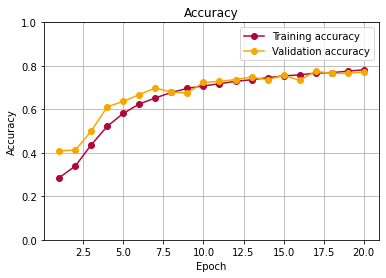

In [14]:
#--Training--#
history = models[3].fit(
  X_train, y_train, #Trainingsdaten generieren
  validation_data = valid_data, #Validierungsdaten generieren
  epochs = 20, #anzahl durchgänge
)

#--Trainings und Validierungsgenauigkeit anzeigen--#
helpers.plot_history("Accuracy", history, 0)

#Direkt abspeichern bevor Laufzeit abbrechen könnte
models[3].save("DeepPiCar")
!zip -r ./CNN.zip ./DeepPiCar/
models[3].save("DeepPiCar.pb")
models[3].save("DeepPiCar.h5")

# Teil 7 - Evaluieren

In [15]:
model = load_model("DeepPiCar")

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 41, 54, 3)]       0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 41, 54, 256)       19456     
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 20, 27, 256)       0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 20, 27, 320)       2048320   
_________________________________________________________________
MaxPool2D_2 (MaxPooling2D)   (None, 10, 13, 320)       0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 10, 13, 394)       3152394   
_________________________________________________________________
MaxPool2D_3 (MaxPooling2D)   (None, 5, 6, 394)         0   

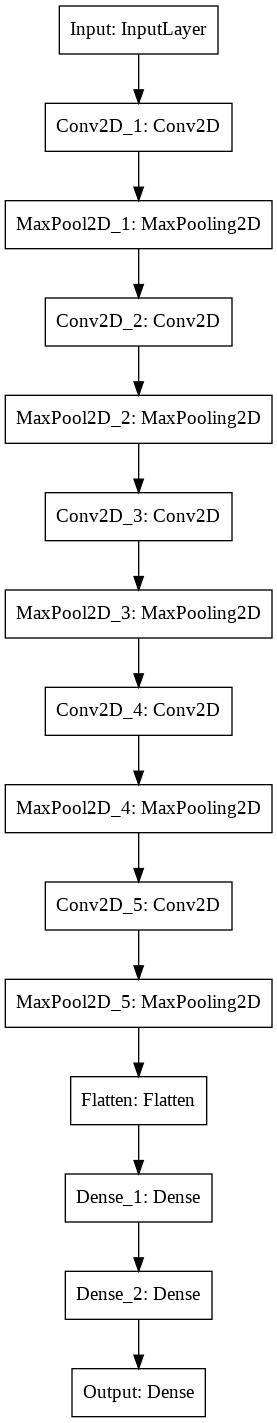

In [17]:
print(model.summary())
tf.keras.utils.plot_model(model, to_file="cnn.png")

In [ ]:
#--kategorisch in numerisch umwandeln--#
def auswertung_steuerwinkel(y):
  max = 0
  for i in range(len(y)):
    if(y[i] > y[max]):
      max = i
  return max 

#--Vorhersagen--#
def vorhersage(X):
  model = load_model('DeepPiCar.h5')
  y_pred = model.predict(X)
  return y_pred

In [ ]:
#--Testdaten generieren--#
bs = 50
test_batches = ImageDataGenerator().flow_from_directory(valid_dir, target_size = (73, 54), classes=classes, batch_size = bs)
X_test, y_test = next(test_batches)
X = []
for i in range(bs):
  X.append(X_test[i, 32: ,:])
X_test = np.asarray(X)
y_pred = vorhersage(X_test)

Gemessener Winkel = 80, Vorhergesagter Winkel = 80


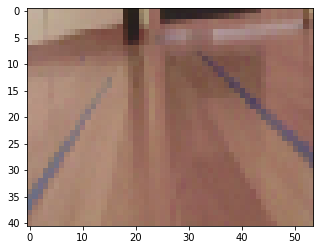

In [ ]:
#--Anzeigen--#
num = random.randint(0, bs - 1)
gemessener_winkel = vorbereitung_steuerwinkel(y_test[num]) * 10
ausgewerteter_winkel = auswertung_steuerwinkel(y_pred[num]) * 10
print(f"Gemessener Winkel = {gemessener_winkel}, Vorhergesagter Winkel = {ausgewerteter_winkel}")
plt.imshow(X_test[num] / 255) #damit werte von 0 bis eins sind für pyplot